# Monte Carlo Control

We alternate a single MC evaluation step and a single decaying epsilon-greedy action-selection improvement step. We use a simple slippery walk seven environment:a single-row walk grid-world environment, with seven non-terminal states with actions effected by stochastic. This environment is noisy, but the actions the agent selects make a difference in its performance.

In [1]:
import random
import numpy as np
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 9
        self.action_space = 2
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [2]:
slippery_walk = SlipperyWalk()

The optimal state value function can be caluculated using the MDP and appliyng the Dynamic Programmaing:

In [15]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]  

We need a decay schedule function for exploration (epsilon), for evaluation (alfa) and discounts

In [3]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [12]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

A function to generate a trajectory:

In [4]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):

    # list of experiences (trajectory)
    trajectory = []

    done = False
    steps = 0

    # reset the environment to interact in a new episode
    state = env.reset()

    # looping through until the done flag is set to true
    while not done:
        steps += 1; 

        # here is the difference: use the ‘select_action’ 
        # function to pick an action
        action = select_action(state, Q, epsilon) 
            
        # step the environment using that action
        next_state, reward, done, _ = env.step(action)

        # append the experience to the trajectory
        experience = (state, action, reward, next_state, done)
        trajectory.append(experience)
        
         # if we hit a terminal state break and return
        if done:
            break

        # truncate long trajectories 
        if steps > max_steps:
            break;   
       
        # update the state
        state = next_state
    
    # return the trajectory
    return np.array(trajectory, object)

We now estimate the action-value function Q and we explore using a decaying epsilon strategy:

In [6]:
def select_action(state, Q, epsilon):
    if np.random.uniform() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(len(Q[0]))

    return action;

In [9]:
def mc_control(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
               n_episodes=2000, max_steps=200):
    
    nS, nA = env.observation_space, env.action_space
    
    # calculate all discounts at once. 
    discounts = decay_discounts(gamma, max_steps);
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
        
    # calculate all epsilons in advance
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    # setting up variables
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # the episode loop    
    for e in range(n_episodes):
        
        # generate a trajectory using the exploratory policy
        trajectory = generate_trajectory(select_action, Q, epsilons[e], env, max_steps)
        
        # keep track of the visits to state-action pairs
        visited = np.zeros((nS, nA), dtype=bool)
        
        # process the trajectory offline, after the interactions with the 
        # environment have stopped
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            
            # check for state-action pair visits
            if visited[state][action]: 
                continue
            visited[state][action] = True
            
            # calculate the return and estimate the value function (Q this time)
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])
            V = np.max(Q, axis=1)

        # save values for post analysis
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    
    # at the end, we extract the state-value function and the greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

Let’s use the algorithms to optimize an agent for the Slippery Walk Seven environment:

In [13]:
Q_mc, V_mc, pi_mc, Q_track_mc, V_track_mc, pi_track_mc = mc_control(slippery_walk)

In [14]:
print(V_mc)

[0.         0.6296097  0.86715704 0.95747574 0.98141843 0.99901468
 0.99942563 0.99999829 0.        ]


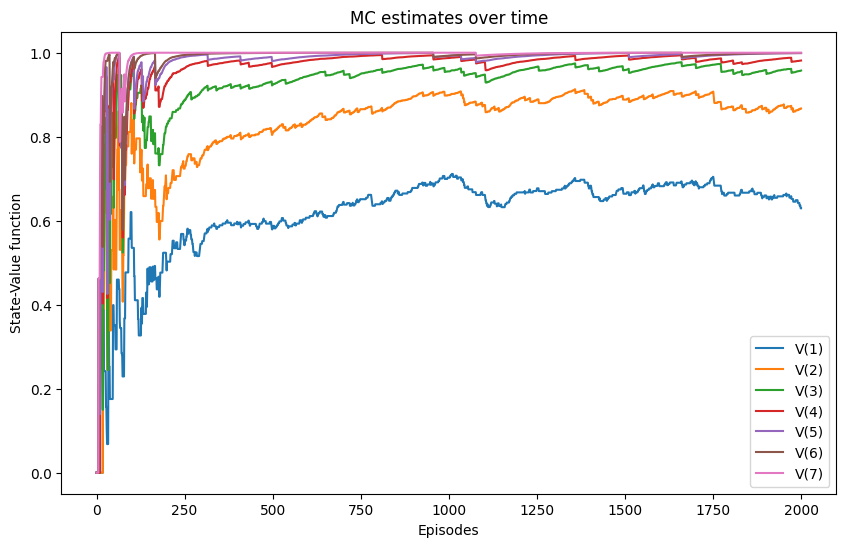

In [15]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))
plt.plot(V_track_mc[:,1:8])
plt.title('MC estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

Notice how the estimates of MC have high variance. We can use a brute-force approach to get the average return of the policy and its success probability.

In [16]:
def evaluate(env, pi, n_episodes=1000, max_steps=200):
    success = 0;
    results = []
    for _ in range(n_episodes):
        done = False;
        steps = 0;
        state = env.reset();
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward;
            steps += 1
        if(done and reward==1):
            success += 1;
    return (success/n_episodes)*100, np.mean(results);

In [17]:
probability_success, mean_return = evaluate(slippery_walk, pi_mc);

print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  91.8 %
Obtains an average undiscounted return of  0.918
